# Binary Classification of Brain Tumours using a Support Vector Machine (SVM) with SIFT feature extraction and k-Means clustering.

For more information on the background of this notebook, please see README.md and the supplementary report. A summary of the entire workflow of this notebook and the motivation behind it is given there.

In [1]:
# Utility libraries
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

# Machine learning and image management libraries
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

The cell below defines key constants of the notebook below. These are free to be changed

The data is loaded from locations relative this directory. Change the dataset location as necessary below.
The below two cells work under the assumption that the filenames and labels located in 'label.csv' exactly match the images found in the 'images' directory, for both the dataset and the external test set.

In [21]:

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
DATASET_LOCATION = "..\\..\\Assignment Kit\\dataset\\images\\"
DATASET_LABEL_LOCATION = "..\\..\\Assignment Kit\\dataset\\label.csv"

# First is a directory containing the images themselves.
# Second is a csv file containing filenames and labels.
TEST_SET_LOCATION = "..\\..\\Assignment Kit\\test_set\\images\\"
TEST_SET_LABEL_LOCATION = "..\\..\\Assignment Kit\\test_set\\label.csv"

# The directory in which to store pre-processed images, or the directoy in which
# pre-processed images will be found if they have already been pre-processed.
PROCESSED_DATASET_LOCATION = "..\\..\\Assignment Kit\\dataset\\processed_images\\"

# Directory to (optionally) save data produced throughout notebook.
# The current value agrees with .gitignore.
DATA_SAVE_LOCATION = "SVM_SFT_saved_data\\"
TRAINING_SET_FILENAME = "train_set.npy"

# Defines range of K values (hyperparameter) to try. Note: Most be postive integers.
# Number of K values tried is (STOP - START) / STEP.
# Syntax is np.arange(START, STOP, STEP)
# STOP is not inclusive hence increment it by STEP to ensure it is in included.
K_VALS = np.arange(10, 100 + 10, 10).tolist()

# Defines range of hyperparameter for regularisation C = 1 / \lambda used when cross validating SVMs.
C_VALS = np.arange(0.001, 0.08 + 0.001, 0.001).tolist()

# Flags to change operation of notebook. Flag names are informative.
EXTRACT_FEATURES_EVEN_IF_EXTRACTED_BEFORE = False 
SHOW_SIFT_FEATURE_EXTRACTION_EXAMPLE = True
SAVE_TRAIN_SET_OF_ALL_DESCRIPTORS = True
SAVE_TEST_SET_OF_ALL_DESCRIPTORS = False
FIND_K_MEANS_CLUSTERS_EVEN_IF_FOUND_BEFORE = False
SAVE_K_MEANS_CENTRES = True
K_MEANS_NUMBER_OF_RUNS = 1                          # Per K value
K_MEANS_MAX_ITERATIONS = 200                        # Per run per K value
K_MEANS_VERBOSE_LEVEL = 6                           # Set this is 0 for no output, 6 for max output.

if (SAVE_TRAIN_SET_OF_ALL_DESCRIPTORS
    or SAVE_TEST_SET_OF_ALL_DESCRIPTORS):
    if not os.path.isdir(DATA_SAVE_LOCATION):
        os.mkdir(DATA_SAVE_LOCATION)

print("#K_VALS = {}. K_VALS = {}.".format(len(K_VALS), K_VALS))
print("#C_VALS = {}. C_VALS = {}.".format(len(C_VALS), [float("%.4f" % C) for C in C_VALS]))

#K_VALS = 10. K_VALS = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100].
#C_VALS = 80. C_VALS = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08].


In [22]:
# Loads data into numpy array of strings.
# Header is skipped as given by skip_header = 1.
# The header in the expected file is "file_name" and "label".
# Therefore, indexing the 0'th element in a row references the filenames and indexing the 1'th element in a row references the label

data = np.genfromtxt(DATASET_LABEL_LOCATION, delimiter = ',', dtype = str, skip_header = 1)

# As this a binary classification task, we can rename all labels which are not 'no_tumor' to 'tumor'.
# This will prevent many further comparisons in future.
for i in range(data.shape[0]):
    if (data[i][1] != "no_tumor"):
        data[i][1] = "tumor"

print("There are {} images in the dataset.".format(data.shape[0]))

There are 3000 images in the dataset.


## Data Pre-Processing

The images in the dataset are given as RGB images. This means that each pixel has three corresponding values due to the three colour channels. In the analysis given here, only the greyscale images are needed. That is, each pixel only has one corresponding due to the single colour channel. To enforce this, we pre-process the images to save them in greyscale format. These are then saved in an alternate directory as given by `PROCESSED_DATASET_LOCATION`.

Additionally, the SIFT functionality as implemented by `sklearn` only accepts single colour channel images of unsigned 8 bit datatype. Therefore, the images formed below are normalised as such. Min-Max normalisation here is used with relative safety as much of the dataset does not include spikes in intensity that would force the normaliser to fully normalise any details away. However, this method can lead to some images in the dataset being more 'illuminated' than others. Even though this is the nature of the un-pre-processed dataset anyways, fortunately the SIFT feature detection method is robust to illumination variation.

To ensure that the images are read correctly after they have been processed, the flag `cv2.IMREAD_GRAYSCALE` must be passed when calling `cv2.imread( ... )`.

In [23]:
if not (os.path.isdir(PROCESSED_DATASET_LOCATION)):
    os.mkdir(PROCESSED_DATASET_LOCATION)

    for i in range(data.shape[0]):
        image_string = "IMAGE_" + str(i).zfill(4)
        
        image = cv2.imread(DATASET_LOCATION + image_string + ".jpg")
        
        # Convert colour image to greyscale
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Normalise image such that pixel values are unsigned 8 bit
        processed_image = cv2.normalize(grey_image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
        
        cv2.imwrite(PROCESSED_DATASET_LOCATION + image_string + ".jpg", processed_image)
        
        if (i % 100 == 0):
            print("{} images processed.".format(i))
            
    print("Image processing done! {} images were processed!".format(data.shape[0]))
    
else:
    print("Data has already been pre-processed!")

Data has already been pre-processed!


Now, we output some random examples from the dataset just to visualise what we are working with. Feel free to run the cell multiple times to see more images in the dataset.

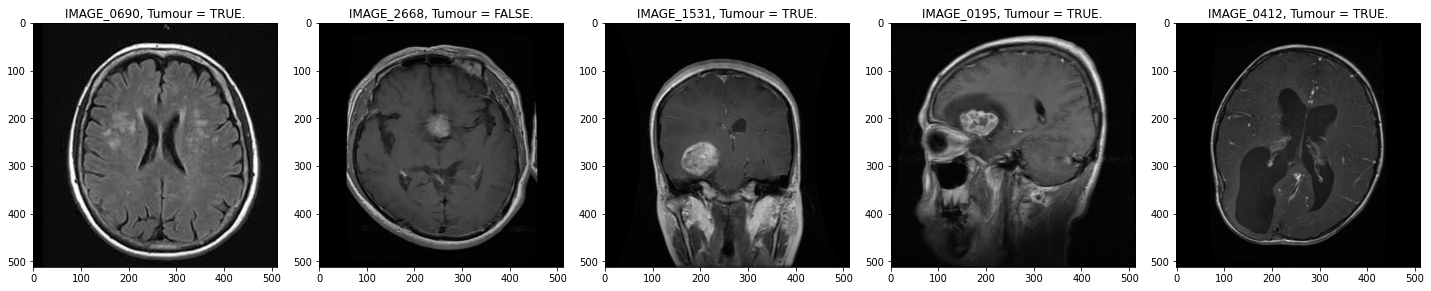

In [24]:
fig, ax = plt.subplots(1, 5, figsize = (20, 4))

for i in range(5):
    image_num = np.random.randint(0, data.shape[0] - 1)
    image_string = "IMAGE_" + str(image_num).zfill(4)
    
    ax[i].imshow(cv2.imread(PROCESSED_DATASET_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE), cmap = "gray")
    ax[i].set_title("{}, Tumour = {}.".format(image_string, "TRUE" if (data[i][1] != "no_tumor") else "FALSE"))
    
plt.tight_layout()

## SIFT Feature Extraction and Compilation

Here, the SIFT framework is used to extract SIFT keypoints and their corresponding descriptors from the images in the dataset.

There are a few free/hyper parameters that are available for exploration. These parameters include the SIFT parameters: the number of octaves, the number of scale levels, the standard deviation used in the Laplacian of Gaussian (LoG) operation $\sigma$, and others. Another hyperparameter is the number of centroids/cluster's provided to the k-Means clustering algorithm $K$. This hyperparameter $K$ is the only hyperparameter explored here due to the SIFT parameters exerting significantly less influence on the final accuracy when compared to $K$.

ALL SIFT features extracted from the training set images are used. This may seem excessive however this is deemed possible with the help of a brief calculation, as follows. The 3000 images in the dataset appear to have an average of 1000 features (empircally found). The descriptor for each feature is 128 dimensional vector with each entry being an unsigned integer small enough to fit inside an unsigned byte representation - 8 bits. Therefore, the minimum memory requirement for storing the feature descriptors for future k-means clustering can be justified to be $3000 \times 1000 \times 128 \times 8 \approx 3 \times 10^{9}$ bits. This is approximately 300 megabytes. This is well within the memory capabilities of most modern machines even if the language used is Python which of course it is here.

750 key points found in example image "IMAGE_1258".
For example, key point 638 of the image is represented by the following descriptor vector:
[ 44  58  19  17   4   6   8  45   9  12  23  40  17  40  25  24  17  14
  40   5   1   3  51 116   6   1   7   5  21   8  58 122  47   8   5   8
  16  14  29 122  29   9   5  27 120  50  29  37 122  26   4   5   8   3
  22 107  34   7   6  65  77   7  32  60  44  36  72  33  11   5   4  28
  47   8  37  49  63  11  24  77 122  13   7  36   9   2  18 122  19   9
  31 122  32   0   0   2  11   4  12   6   5  30  37  21 101  10  13   6
   1  10  16  53  27   8  22 122  20   0   2  26   5   2   8 122  59   7
  16  14]


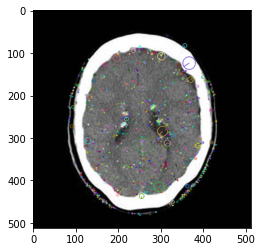

In [25]:
if (SHOW_SIFT_FEATURE_EXTRACTION_EXAMPLE):
    sift = cv2.SIFT_create()
    
    image_string = "IMAGE_" + str(np.random.randint(0, data.shape[0] - 1)).zfill(4)
    image = cv2.imread(PROCESSED_DATASET_LOCATION + image_string + ".jpg", cv2.IMREAD_GRAYSCALE)
    
    key_points, descriptors = sift.detectAndCompute(image, None)
    descriptors = descriptors.astype(np.ubyte)
    
    image = cv2.drawKeypoints(image, key_points, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    print("{} key points found in example image \"{}\".".format(len(key_points), image_string))
    
    example_desc_num = np.random.randint(0, len(key_points))
    print("For example, key point {} of the image is represented by the following descriptor vector:".format(example_desc_num))
    print(descriptors[example_desc_num])
    
    plt.imshow(image)

In [26]:

def build_set(data_, filename):
    # Given a (N \times 2) numpy array with the first column containing the filenames of the images
    # and the second row containing the images labels (as given with the data for this task),
    # this function returns a list of the descriptors of the features found from images in the dataset.
    # The array desc_set is re-sized for every image which makes this function fairly clunky. However, this is
    # by far the simplest method to implement it. An attempt was made to implement it by estimating the total number
    # of descriptors to prevent frequent re-allocation but in the end Occam's razor prevails.
    # Parameter data_ is named as such to prevent confusion with the global 'data' used elsewhere in this notebook.
    
    print("Beginning feature extraction and computation...")
    
    sift = cv2.SIFT_create()
    
    desc_set = np.empty((0, 128), dtype = np.ubyte)
    
    for i in range(data_.shape[0]):
        
        if ((i % 100 == 0) and (i != 0)):
            print("Features extracted and processed from {} images.".format(i))
        
        image = cv2.imread(PROCESSED_DATASET_LOCATION + "IMAGE_" + str(i).zfill(4) + ".jpg", cv2.IMREAD_GRAYSCALE)
        
        key_points, descriptors = sift.detectAndCompute(image, mask = None)
        
        descriptors = descriptors.astype(np.ubyte)
        
        desc_set = np.append(desc_set, descriptors, axis = 0)
        
    print("Features extracted and processed from {} images.".format(data_.shape[0]))
    
    print("Finished building {}.".format(filename))
    
    # Save generated description set if told to
    if (SAVE_TRAIN_SET_OF_ALL_DESCRIPTORS):
        np.save(DATA_SAVE_LOCATION + filename, desc_set)
        print("{} successfully saved.".format(DATA_SAVE_LOCATION + filename))
    
    return desc_set

In [27]:

if (EXTRACT_FEATURES_EVEN_IF_EXTRACTED_BEFORE):
    train_set = build_set(data, TRAINING_SET_FILENAME)
    
else:
    # Attempt to load previous pre-processed training set
    try:
        train_set = np.load(DATA_SAVE_LOCATION + TRAINING_SET_FILENAME)
        print("Training set successfully loaded from {}.".format(DATA_SAVE_LOCATION + TRAINING_SET_FILENAME))
        
    except FileNotFoundError:
        print("Training set could not be loaded from {}.".format(DATA_SAVE_LOCATION + TRAINING_SET_FILENAME))
        
        train_set = build_set(data, TRAINING_SET_FILENAME)

print("For sanity checking, the shape of the training set numpy array is ({}, {}).".format(train_set.shape[0], train_set.shape[1]))

Training set successfully loaded from SVM_SFT_saved_data\train_set.npy.
For sanity checking, the shape of the training set numpy array is (2717148, 128).


# Using k-Means Clustering to Produce a "Visual Vocabulary"

In [19]:
def find_k_means_clusters():
    pass

# for k in K_VALS:
if (True):
    k = 20
    
    if 
    
    if (FIND_K_MEANS_CLUSTERS_EVEN_IF_FOUND_BEFORE):
        # Initialise kMeans class instance
        kmeans = KMeans(
            n_clusters = k,
            init = "k-means++",
            n_init = K_MEANS_NUMBER_OF_RUNS,
            max_iter = K_MEANS_MAX_ITERATIONS,
            verbose = K_MEANS_VERBOSE_LEVEL
        )
        
        # Run the k-means clustering algorithm
        kmeans.fit(train_set)
    

Initialization complete
Iteration 0, inertia 394588601684.0
Iteration 1, inertia 261407569341.5159
Iteration 2, inertia 255619444358.28693
Iteration 3, inertia 252899131281.8032
Iteration 4, inertia 251235281089.639
Iteration 5, inertia 250127678649.50992
Iteration 6, inertia 249355599554.18204
Iteration 7, inertia 248758853918.3668
Iteration 8, inertia 248192504957.591
Iteration 9, inertia 247691884666.56747
Iteration 10, inertia 247350726348.23865
Iteration 11, inertia 247110732365.96857
Iteration 12, inertia 246933036588.38324
Iteration 13, inertia 246796230154.31497
Iteration 14, inertia 246690849461.04257
Iteration 15, inertia 246611005166.83353
Iteration 16, inertia 246549659331.56818
Iteration 17, inertia 246503864180.53168
Iteration 18, inertia 246470307110.66968
Iteration 19, inertia 246445132063.99637
Iteration 20, inertia 246426509829.0093
Iteration 21, inertia 246412641973.38962
Iteration 22, inertia 246402067555.9368
Iteration 23, inertia 246393842609.2271
Iteration 24, in

## Dimensionality Reduction Measures